# Google Play app reviews dataset

This notebook is almost entirely based on the following notebook:
https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.5
IPython 7.13.0

numpy 1.16.6
pandas 0.25.2
torch 1.2.0
transformers 3.1.0


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

In [3]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

In [4]:
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', 
        palette='muted', 
        font_scale=1.2)

#### Setting params for sns

In [6]:
sns.set(style='whitegrid', 
        palette='muted', 
        font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", 
                        "#FFDD00", 
                        "#FF7D00", 
                        "#FF006D", 
                        "#ADFF02", 
                        "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#### Run on Cuda

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Read Dataset

In [8]:
path = '/home/atabaja/AI-madrid/sentiment-analysis/'

In [9]:
df = pd.read_csv(path + "reviews.csv")

#### Basic checks

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
userName                15746 non-null object
userImage               15746 non-null object
content                 15746 non-null object
score                   15746 non-null int64
thumbsUpCount           15746 non-null int64
reviewCreatedVersion    13533 non-null object
at                      15746 non-null object
replyContent            7367 non-null object
repliedAt               7367 non-null object
sortOrder               15746 non-null object
appId                   15746 non-null object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [11]:
df.shape

(15746, 11)

In [12]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [13]:
df.loc[0, "content"]

"Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK."

#### Histogram for review scores

In [88]:
score_count = df.groupby('score')['userName'].agg({'userName': 'count'})

/home/atabaja/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


In [89]:
score_count

,userName
score,
1,2566
2,2462
3,5042
4,2776
5,2900


In [90]:
score_count.rename(columns = {'userName': 'count'}, inplace = True)

In [91]:
score_count

,count
score,
1,2566
2,2462
3,5042
4,2776
5,2900


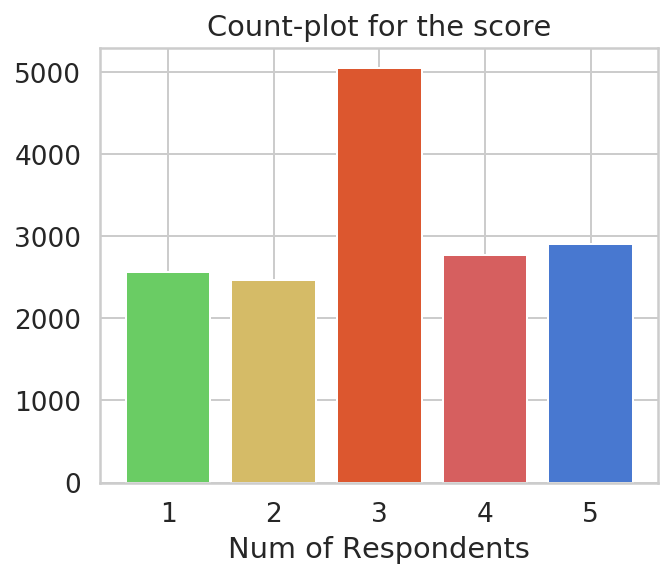

In [96]:
plt.bar(score_count.index, 
        score_count['count'], 
        color = ['g', 'y', '#DC572F', 'r', 'b'])

plt.xlabel("Review Score")
plt.xlabel("Num of Respondents")

plt.title("Count-plot for the score")

fig = plt.gcf()
fig.set_size_inches((5, 4))

plt.show()

----

### Convert to 3 categories to balance labels
Negative, Neutral and Positive

In [97]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [98]:
score_count.reset_index(inplace = True)

In [99]:
score_count['sentiment'] = score_count['score'].apply(to_sentiment)

In [100]:
sentiment_count = score_count.groupby('sentiment')['count'].sum()

In [101]:
sentiment_count = pd.DataFrame(sentiment_count)

In [102]:
sentiment_count.reset_index(inplace = True)

In [104]:
sentiment_cats = ['Negative', 
                  'Neutral', 
                  'Positive']

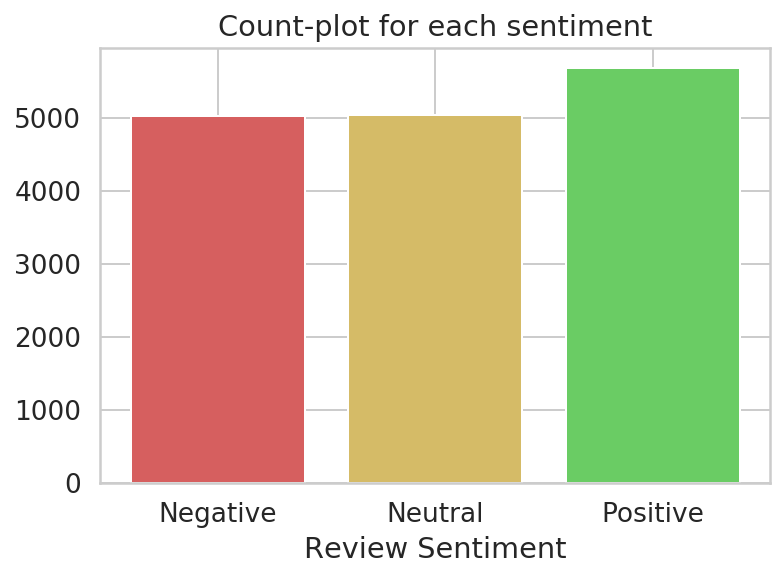

In [105]:
# Plot
plt.bar(sentiment_count['sentiment'], 
        sentiment_count['count'],
        color = ['r', 'y', 'g'])

plt.xticks(ticks = sentiment_count['sentiment'], 
          labels = sentiment_cats)

# labels
plt.xlabel("Review Sentiment")
plt.title("Count-plot for each sentiment")

fig = plt.gcf()
fig.set_size_inches(6, 4)

plt.show()

----

# Data Preprocessing

In [106]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

#### Tokenization

In [107]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [108]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Tokenize

In [109]:
# Tokenize (here it will separate)
tokens = tokenizer.tokenize(sample_txt)

Tokens to ids

In [110]:
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)

What has been done? Let's peek

In [112]:
print(f'Sentence: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {tokens_ids}')

Sentence: When was I last outside? I am stuck at home for 2 weeks.
Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


Obviously, BERT's special tokens were not added

### BERT's Special tokens

[SEP]

In [33]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS]

In [34]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

[PAD]

In [35]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

[UNK]

In [36]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### Encode_plus: encoding all in one place
With paddings and Special tokens added

In [113]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Deciding the max len
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [114]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [40]:
len(encoding['input_ids'][0])

32

In [41]:
encoding['input_ids'][0] # Tensor of of shape (1, 32)

tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Attention mask tells which tokens are real
and which are paddings

In [42]:
encoding['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

#### Convert from ids to tokens
Also possible!

In [115]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])[:10]

['[CLS]', 'When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck']

---

---

### How to choose the sequence max length?

In [116]:
tokens_len = []

In [117]:
for txt in df.content:
    tokens = tokenizer.encode(txt, 
                              truncation=True,
                              max_length = 512)
    tokens_len.append(len(tokens))

#### SNS Distribution Plot

Text(0.5, 0, 'Token count')

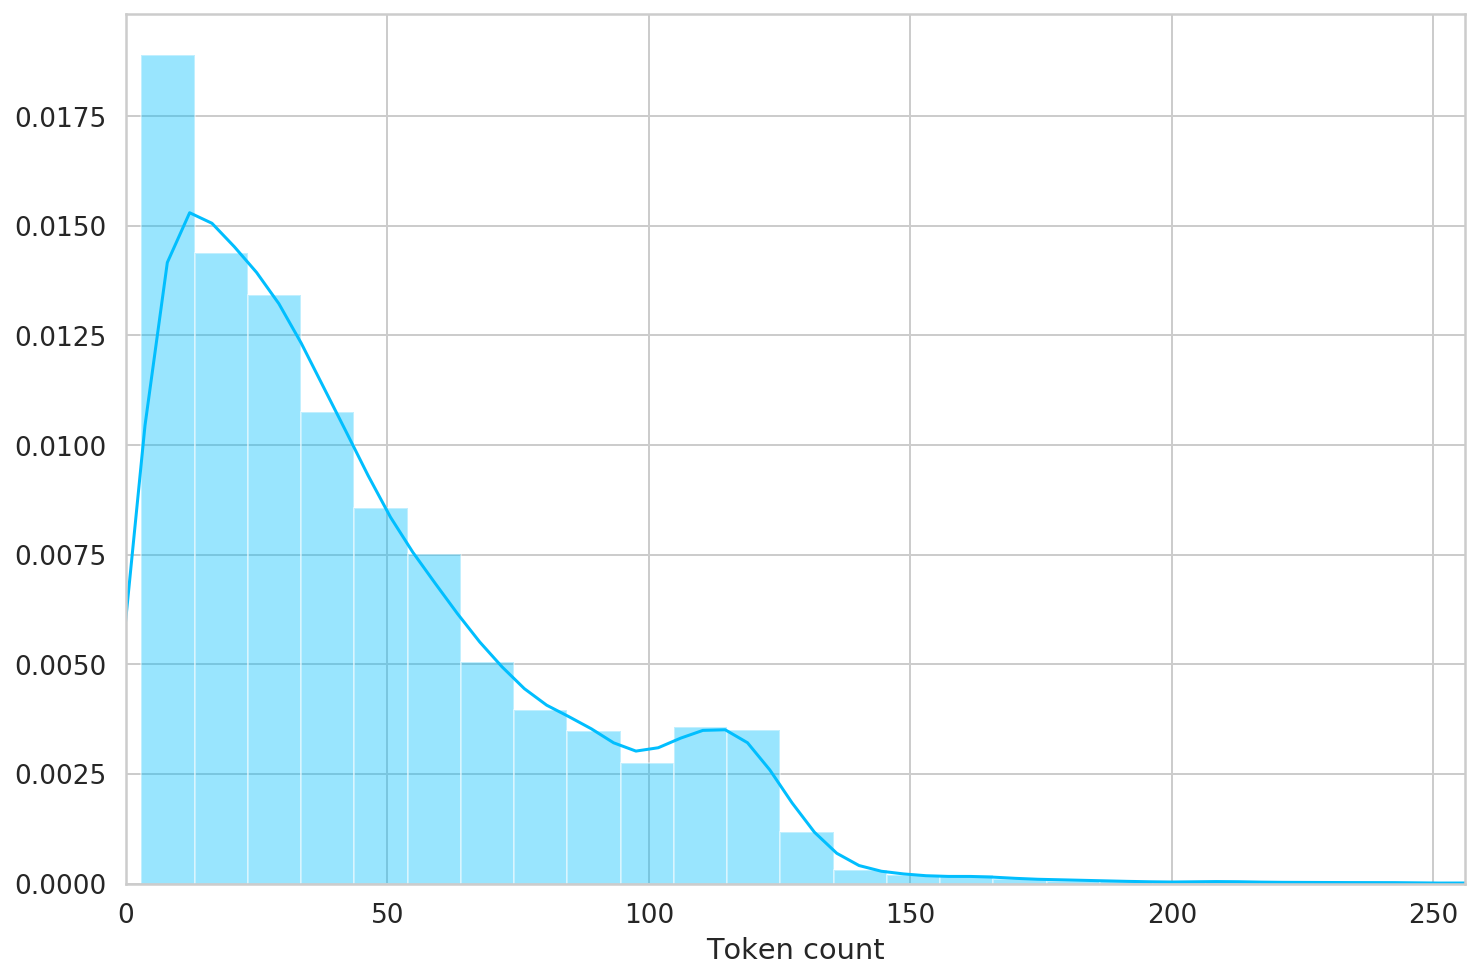

In [118]:
sns.distplot(tokens_len)
plt.xlim([0, 256])

plt.xlabel('Token count')

In [119]:
MAX_LEN = 160

----

----

# Creating datasets and dataloaders

In [48]:
df['sentiment'] = df['score'].apply(to_sentiment)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 12 columns):
userName                15746 non-null object
userImage               15746 non-null object
content                 15746 non-null object
score                   15746 non-null int64
thumbsUpCount           15746 non-null int64
reviewCreatedVersion    13533 non-null object
at                      15746 non-null object
replyContent            7367 non-null object
repliedAt               7367 non-null object
sortOrder               15746 non-null object
appId                   15746 non-null object
sentiment               15746 non-null int64
dtypes: int64(3), object(9)
memory usage: 1.4+ MB


## Dataset

We must inherit from Pytorch Dataset

In [122]:
class GPReviewDataset(Dataset):
    
    # __INIT__ METHOD
    def __init__(self, 
                 reviews, 
                 labels, 
                 tokenizer, 
                 max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # __LEN__ METHOD
    def __len__(self):
        return len(self.reviews)
    
    # __GetItem__ METHOD
    def __getitem__(self, index):
        review = self.reviews[index]
        label = self.labels[index]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            truncation=True,
            max_length = self.max_len,
            return_token_type_ids = False,
            padding='max_length',
            return_attention_mask = True,
            return_tensors = 'pt')
        
        ret_val = {}
        # Raw text
        ret_val['review_text'] = review
        
        # Important tensors
        ret_val['input_ids'] = encoding['input_ids'].flatten()
        ret_val['attention_mask'] = encoding['attention_mask'].flatten()
        
        # Target tensor
        ret_val['targets'] = torch.tensor(label, dtype = torch.long)
        
        return ret_val

### Split to Train, Validation and Test sets

In [51]:
df_train, df_test = train_test_split(df, 
                                    test_size = 0.2,
                                    random_state = RANDOM_SEED)

In [52]:
df_val, df_test = train_test_split(df_test, 
                                   test_size = 0.5,
                                   random_state = RANDOM_SEED)

In [123]:
df_train.shape, df_val.shape, df_test.shape

((12596, 12), (1575, 12), (1575, 12))

# DataLoaders

In [54]:
BATCH_SIZE = 16

In [55]:
def create_data_loader(df, 
                       tokenizer, 
                       max_len, 
                       batch_size):
    
    ds = GPReviewDataset(reviews = df.content.to_numpy(),
                        labels = df.sentiment.to_numpy(),
                        tokenizer = tokenizer,
                        max_len = max_len)
    
    return DataLoader(ds, 
                      batch_size = batch_size,
                      num_workers = 4)

In [56]:
train_dl = create_data_loader(df_train, tokenizer,
                             MAX_LEN, BATCH_SIZE)

In [57]:
val_dl = create_data_loader(df_val, tokenizer,
                            MAX_LEN, BATCH_SIZE)

In [58]:
test_dl = create_data_loader(df_test, tokenizer,
                             MAX_LEN, BATCH_SIZE)

Let's peek what a dataloader returns

In [59]:
data = next(iter(train_dl))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [60]:
print(data['input_ids'].shape)
print(data['targets'].shape)
print(data['attention_mask'].shape)


torch.Size([16, 160])
torch.Size([16])
torch.Size([16, 160])


----

----

# Sentiment Classification with BERT and Hugging Face

### Defining a BERT model

In [62]:
PRE_TRAINED_MODEL_NAME

'bert-base-cased'

The model will be in the nn.Module new Model, for memory efficacy we will comment out this code

In [63]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Let's run it on one sample

In [185]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

NameError: name 'bert_model' is not defined

In [128]:
last_hidden_state.shape, pooled_output.shape

NameError: name 'last_hidden_state' is not defined

In [ ]:
bert_model.config.hidden_size

pooled_output can be treated as a "summary" of the entire sentence

### Building a BERT-based classifier

We must inherit from nn.Module

In [61]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        # Init base class:
        super(SentimentClassifier, self).__init__()
        
        # BERT:
        self.bert= BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        
        # Dropout Layer:
        self.drop = nn.Dropout(p=0.3)
        
        # Simple Linear layer at last:
        config_hidden_size = self.bert.config.hidden_size
        self.out = nn.Linear(config_hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask)
    
        drop_output = self.drop(pooled_output)
        return self.out(drop_output)

In [146]:
df.sentiment

0        0
1        0
2        0
3        0
4        0
        ..
15741    2
15742    2
15743    2
15744    2
15745    2
Name: sentiment, Length: 15746, dtype: int64

----

## Creating the model

In [62]:
sentiment_cats

['Negative', 'Neutral', 'Positive']

In [120]:
del model

NameError: name 'model' is not defined

In [119]:
torch.cuda.empty_cache()

In [63]:
model = SentimentClassifier(len(sentiment_cats))

In [64]:
model = model.to(device)

In [65]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [66]:
print(input_ids.shape), print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


(None, None)

#### Predict!

In [67]:
import torch.nn.functional as F

In [68]:
model_out = model(input_ids, attention_mask)

In [69]:
softmax_out = F.softmax(model_out, dim=1)

In [70]:
softmax_out

tensor([[0.4136, 0.1934, 0.3930],
        [0.4886, 0.1446, 0.3668],
        [0.3989, 0.2482, 0.3530],
        [0.6225, 0.1821, 0.1954],
        [0.5256, 0.1611, 0.3133],
        [0.3818, 0.1500, 0.4681],
        [0.6770, 0.1333, 0.1898],
        [0.3832, 0.1974, 0.4194],
        [0.4496, 0.2072, 0.3432],
        [0.5495, 0.1659, 0.2846],
        [0.4283, 0.2726, 0.2992],
        [0.4604, 0.1903, 0.3493],
        [0.5169, 0.1475, 0.3357],
        [0.3500, 0.1569, 0.4931],
        [0.5004, 0.2141, 0.2855],
        [0.4687, 0.2603, 0.2710]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [101]:
softmax_out.shape

torch.Size([32, 3])

In [102]:
_, preds = torch.max(softmax_out, dim=1)
preds

tensor([0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2,
        0, 0, 2, 2, 0, 2, 0, 0], device='cuda:0')

In [103]:
preds.shape

torch.Size([32])

----

----

----

# Training

In [74]:
EPOCHS = 10

In [75]:
len(train_dl)

788

#### Using AdamW Optimizer

In [76]:
optimizer = AdamW(model.parameters(),
                 lr = 2e-5,
                 correct_bias = False)

In [77]:
total_steps = len(train_dl) * EPOCHS

#### Scheduler

In [78]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

In [79]:
loss_fn = nn.CrossEntropyLoss().to(device)

The BERT authors recommended 
- batch = 16,32
- Learning rate (for adamW) of 5e-5, 3e-5, 2e-5
- Num of epochs: 2,3,4, this one will be overlooked

### Helping function 1: Train one epoch

In [84]:
def train_epoch(model, 
               data_loader,
               loss_fn,
               optimizer,
               device,
               scheduler,
               n_examples):
    
    model = model.train()
    
    losses = []
    correct_prediction_sum = 0
    
    for batch in data_loader:
        # Move input to Cuda/GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        # Run model
        outputs = model(input_ids = input_ids,attention_mask = attention_mask)
        
        # Apply Loss
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # Get predictions
        max_vals, preds = torch.max(outputs, dim = 1)
        
        # Sum correct predictions
        curr_sum = (preds == targets).sum().item()
        correct_prediction_sum += + curr_sum
            
        # Backpropagation
        loss.backward()
        ## Avoiding gradient explosion: using clip
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        
        # Reset gradients
        optimizer.zero_grad()
        
        torch.cuda.empty_cache()
        
    acc = correct_prediction_sum * 1.0/n_examples
    loss_mean = np.mean(losses) 
    return acc, loss_mean

### Helping function 2: evaluation 

In [85]:
def eval_model(model, 
               data_loader, 
               loss_fn,
               device,
               n_examples):
    
    # This is needed to avoid dropout
    model = model.eval()
    losses = []
    correct_prediction_sum = 0
    
    # This is needed in order not to store gradients
    with torch.no_grad():
        for batch in data_loader:
            
            # Get input:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            # Run model
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            
            # Calculate loss
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            
            # Get predictions by running MAX
            _, preds = torch.max(outputs, dim = 1)
            curr_sum = (preds == targets).sum().item()
            correct_prediction_sum = correct_prediction_sum + curr_sum
            
            torch.cuda.empty_cache()
        
        acc = correct_prediction_sum*1.0/n_examples
        loss_mean = np.mean(losses)
        return acc, loss_mean

## Training Loop

In [86]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}/{EPOCHS}')
    print("-" * 10)
    
    train_acc, train_loss_mean = train_epoch(model,
        train_dl, loss_fn, optimizer,
        device, scheduler, len(df_train))
    
    print(f'Epoch loss {train_loss_mean} ' + f'accuracy: {train_acc}')

    val_acc, val_loss_mean = eval_model(model, val_dl, loss_fn, device, len(df_val))

    print(f'Epoch loss {val_loss_mean} accuracy: {val_acc}')
    print('*' * 10)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss_mean)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss_mean)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch: 1/10
----------
Epoch loss 1.1367888375360349 accuracy: 0.3452683391552874
Epoch loss 1.1001721728931775 accuracy: 0.3295238095238095
**********
Epoch: 2/10
----------
Epoch loss 1.025716720120556 accuracy: 0.4392664337885043
Epoch loss 0.724462521798683 accuracy: 0.68
**********
Epoch: 3/10
----------
Epoch loss 0.6369190706876178 accuracy: 0.7276119402985075
Epoch loss 0.6292023914630966 accuracy: 0.758095238095238
**********
Epoch: 4/10
----------
Epoch loss 0.3953841029746732 accuracy: 0.854953953636075
Epoch loss 0.6055539198445551 accuracy: 0.8126984126984127
**********
Epoch: 5/10
----------
Epoch loss 0.23661391533495205 accuracy: 0.9248967926325817
Epoch loss 0.7720238464799795 accuracy: 0.833015873015873
**********
Epoch: 6/10
----------
Epoch loss 0.1641048704590743 accuracy: 0.9532391235312798
Epoch loss 0.8151832606003742 accuracy: 0.8476190476190476
**********
Epoch: 7/10
----------
Epoch loss 0.11945072023510026 accuracy: 0.9668942521435376
Epoch loss 0.8924020716

## Accuracy as a function of the epoch
Let's see how the Accuracy changed throughout the training

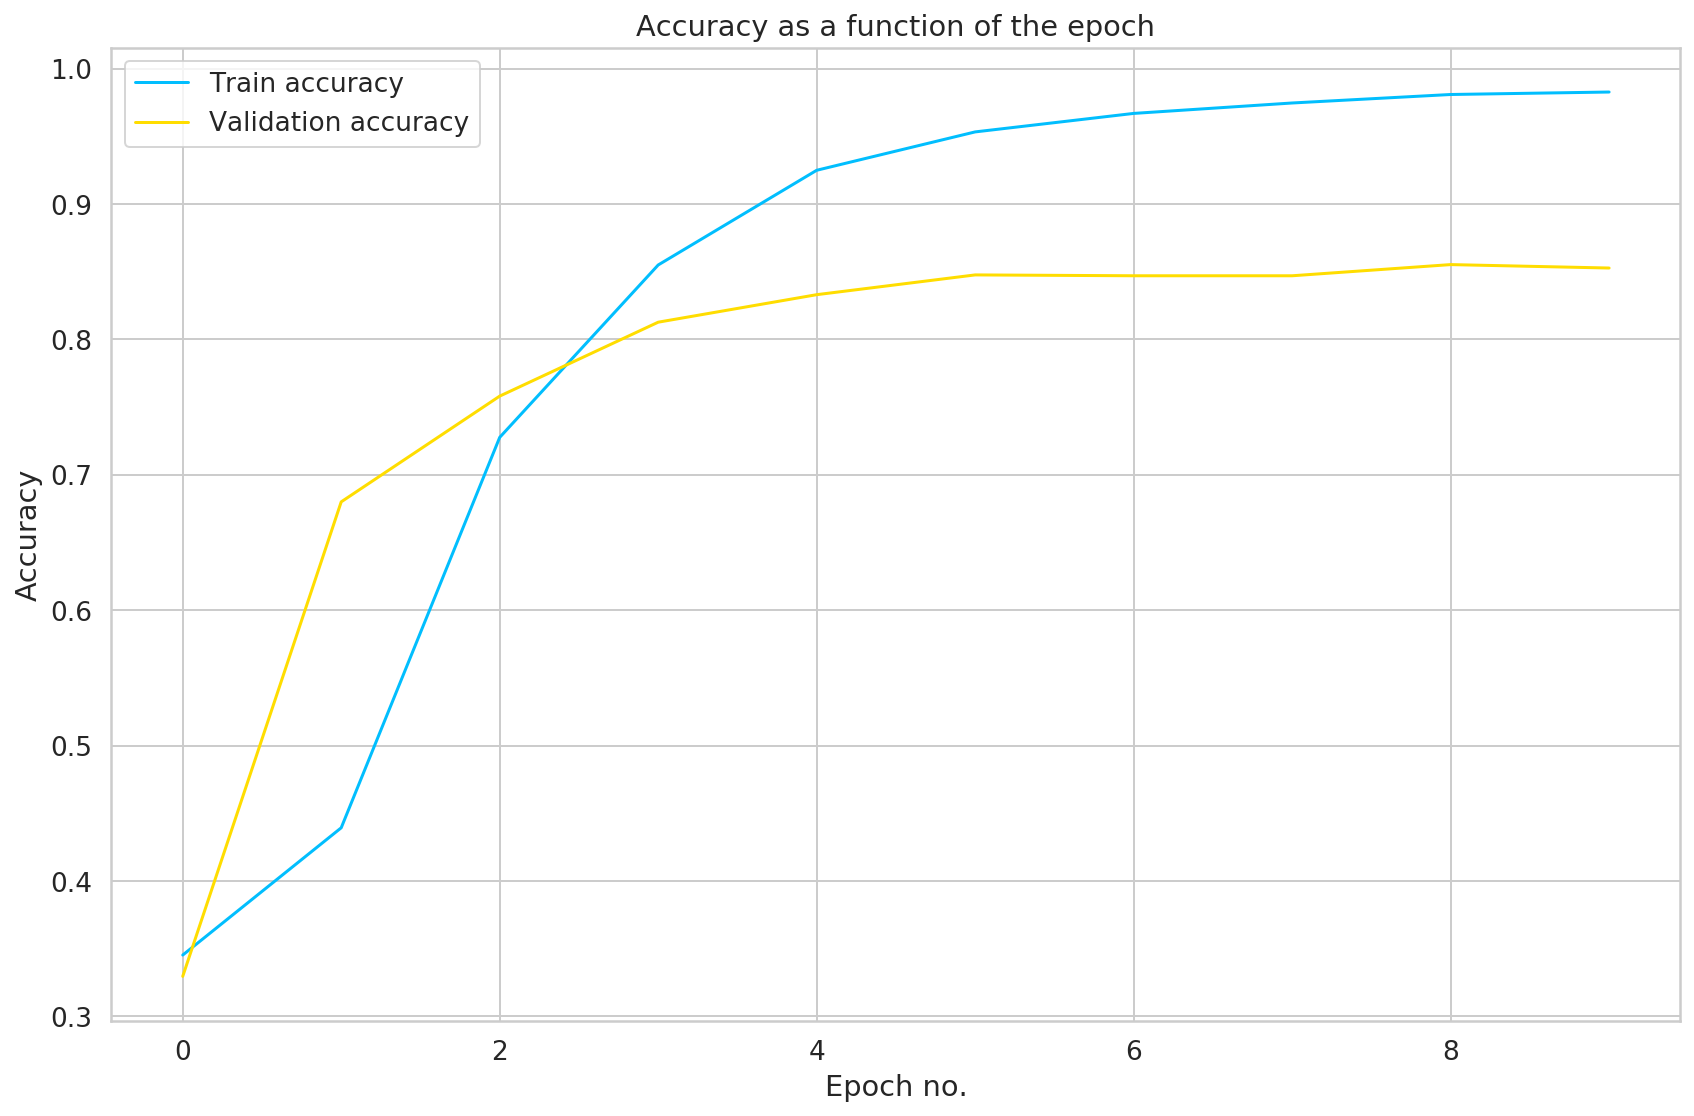

In [130]:
# Plots
plt.plot(history['train_acc'], label = 'Train accuracy')
plt.plot(history['val_acc'], label = 'Validation accuracy')

# Labels
plt.title('Accuracy as a function of the epoch')
plt.xlabel('Epoch no.')
plt.ylabel('Accuracy')

# Finale:
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [131]:
test_acc, test_loss = eval_model(model, test_dl,
                                loss_fn,
                                device,
                                len(df_test))

AttributeError: 'float' object has no attribute 'item'

In [132]:
test_acc

0.846984126984127

----

----

# Evaluation

### Get predictions method

In [138]:
def get_predictions(model, dataloader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for batch in dataloader:
            
            # Unpack and move data to GPU
            texts = batch['review_text']
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            outputs = model(input_ids = input_ids,
                           attention_mask = attention_mask)
            
            _, preds = torch.max(outputs, dim = 1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, \
           prediction_probs, real_values

In [139]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_dl)

[tensor([-0.1708,  4.4650, -3.1250], device='cuda:0'), tensor([-2.1621,  5.8419, -2.5083], device='cuda:0'), tensor([ 5.4986, -3.4906, -3.0166], device='cuda:0'), tensor([-2.6712,  6.3814, -2.2549], device='cuda:0'), tensor([-2.1757,  4.9495, -1.3058], device='cuda:0')]


### Look at the Classification Report

In [141]:
report = classification_report(y_test, y_pred, 
                              target_names = sentiment_cats)

In [149]:
print(report)

              precision    recall  f1-score   support

    Negative       0.92      0.81      0.86       519
     Neutral       0.74      0.85      0.79       466
    Positive       0.89      0.87      0.88       590

    accuracy                           0.85      1575
   macro avg       0.85      0.85      0.85      1575
weighted avg       0.86      0.85      0.85      1575



### Confusion matrix

In [207]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, 
                       annot=True, 
                       fmt="d", 
                       cmap="Blues",
                       square = True)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), 
                              rotation=0, 
                              ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), 
                              rotation=30, 
                              ha='right')
        
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

In [196]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                     index = sentiment_cats, 
                     columns = sentiment_cats)

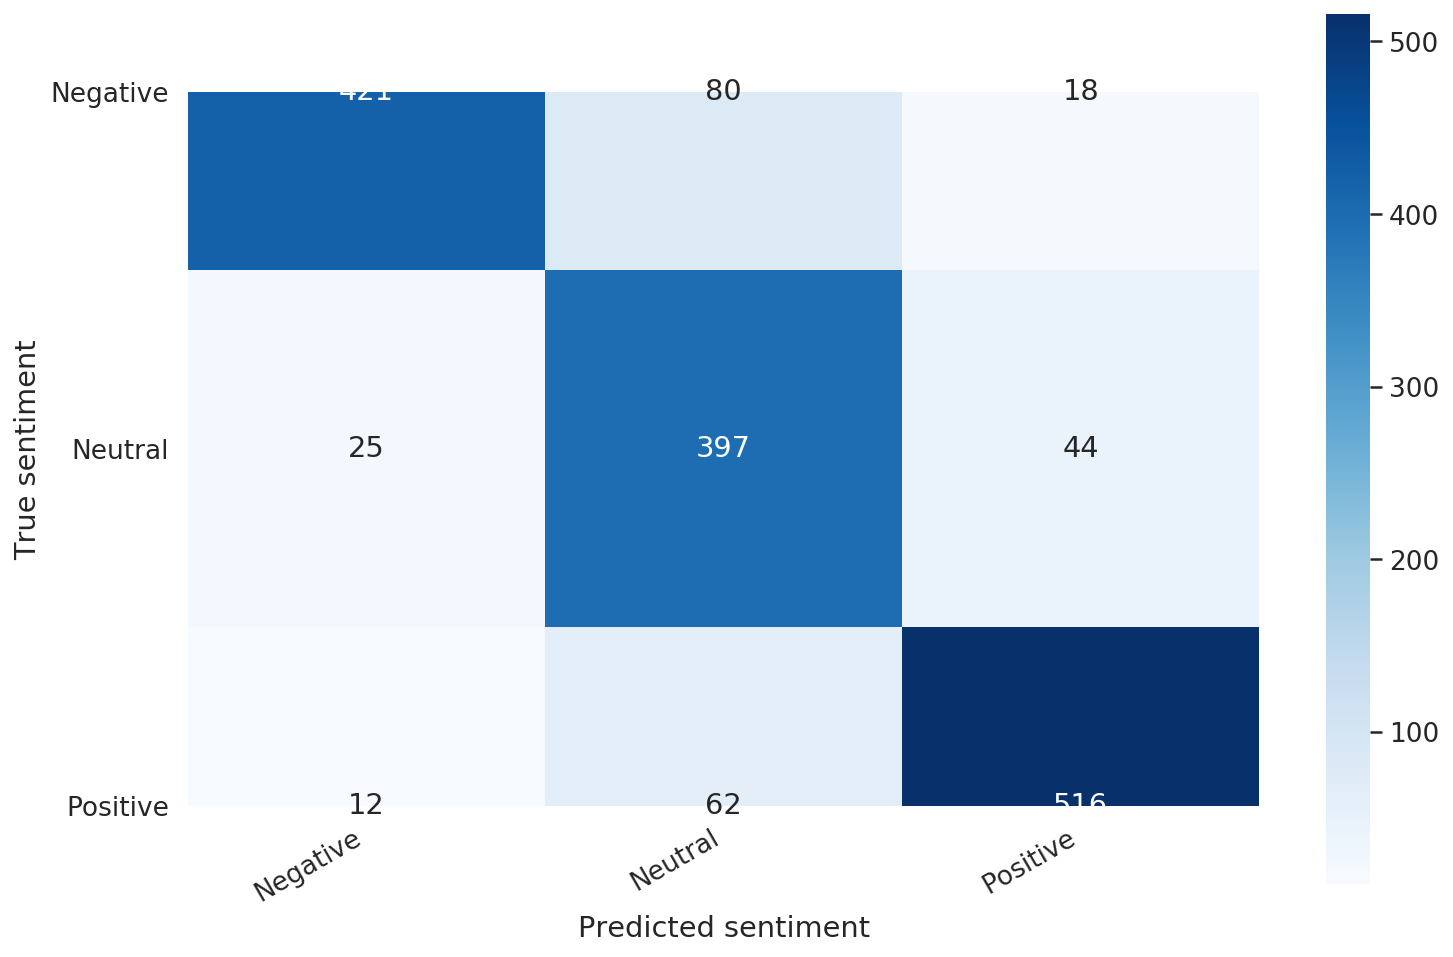

In [208]:
show_confusion_matrix(df_cm)

-----

----

## Let's look at one of the test's examples

In [209]:
idx = 2

In [229]:
probs = torch.nn.Softmax()(y_pred_probs[idx])

/home/atabaja/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [230]:
probs

tensor([9.9968e-01, 1.2471e-04, 2.0033e-04])

In [231]:
review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({'class_names': sentiment_cats,
                        'values': probs})

In [232]:
pred_df

,class_names,values
0,Negative,0.999675
1,Neutral,0.000125
2,Positive,0.000200


In [233]:
review_text

'it doesnt do any thing its gliched everytime i open it'

In [234]:
print("Text:")
print(review_text)
print()
print("True Sentiment:")
print(sentiment_cats[true_label])

Text:
it doesnt do any thing its gliched everytime i open it

True Sentiment:
Negative


Text(0.5, 0, 'Prob')

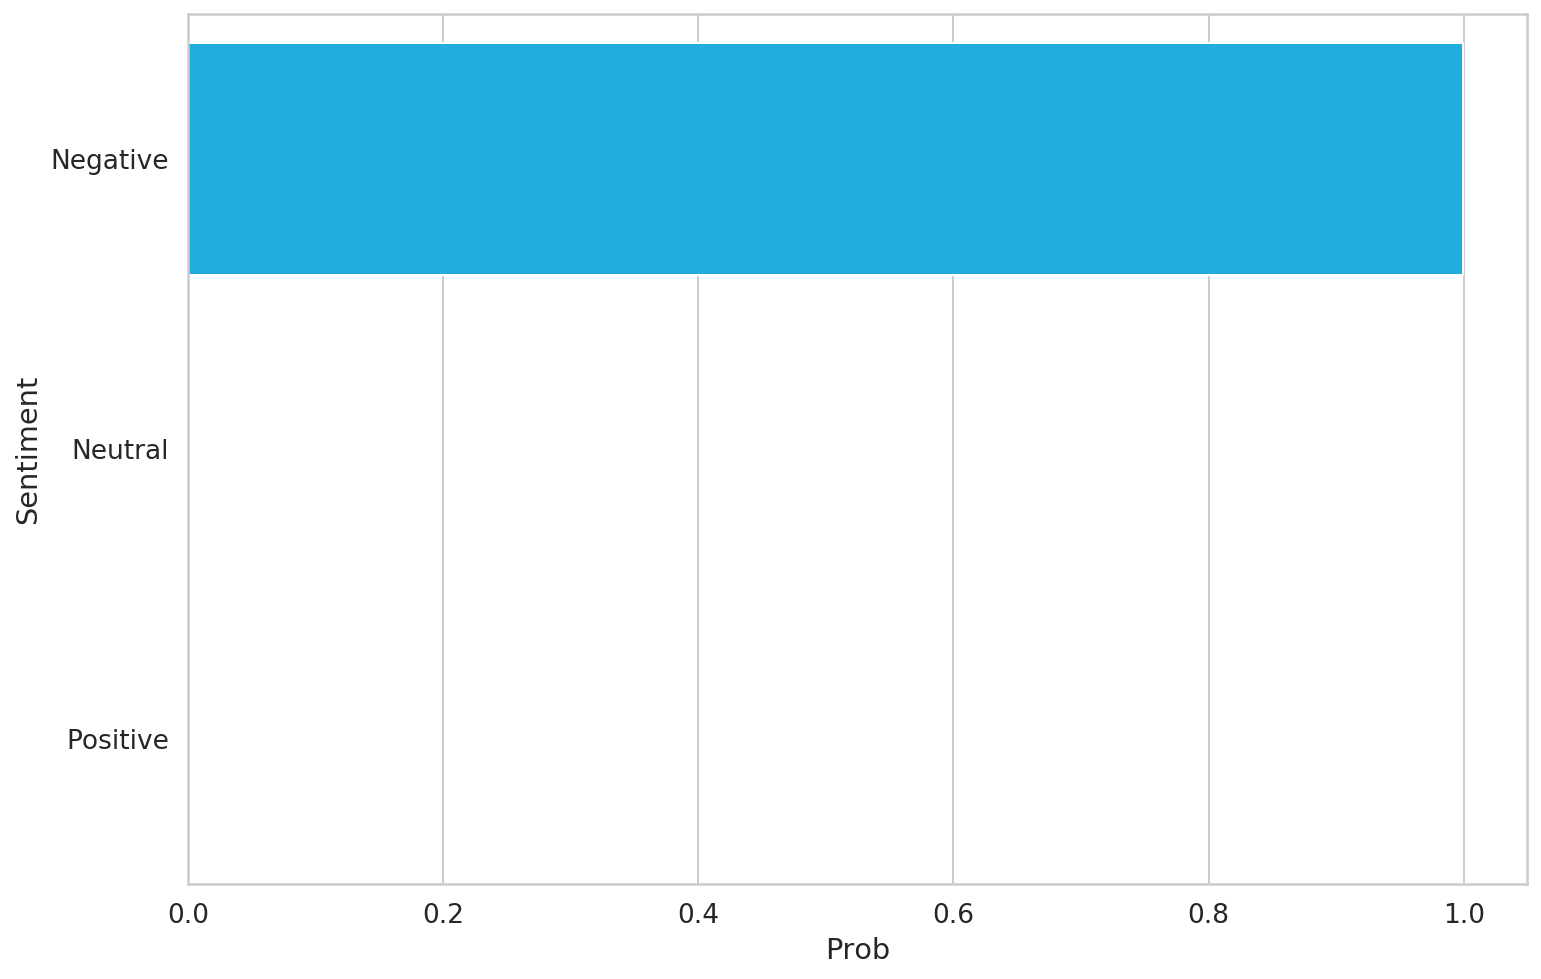

In [237]:
sns.barplot(x='values', y='class_names', data = pred_df, 
           orient = 'h')

plt.ylabel('Sentiment')
plt.xlabel('Prob')

## Predicting on a brand new text (raw)

In [242]:
def predict_on_new_text(review_text):
    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    
    output = model(input_ids = input_ids,
                   attention_mask = attention_mask)
    
    _, pred = torch.max(output, dim=1)
    
    print(f"Review text: {review_text}")
    print(f'Sentiment: {sentiment_cats[pred]}')

In [240]:
new_review = 'I really enjoyed the app, very useful and efficient'

In [243]:
predict_on_new_text(new_review)

Review text: I really enjoyed the app, very useful and efficient
Sentiment: Positive


In [244]:
!ls

README.md  sentiment-analysis  sentiment-analysis-with-bert.ipynb
